To-Dos:
- [ ] Create separate preprocessing piplines both including and excluding features that were used to calculate new features
- [ ] Apply reduced preprocessing to Ridge and KNN; full preprocessing to tree-based models

# Project Description

# Establishing professor's baseline

In [123]:
## Import all needed libraries
import numpy as np
import pandas as pd
import json
import logging
import zipfile
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error

## Initiate common random state
r_state = 123


In [76]:
# Set up logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Log the start of the process
logging.info("Reading train and test files")

# Read the full dataset
data = pd.read_json("train.json", orient='records')
test = pd.read_json("test.json", orient='records')

# Fill missing 'rooms' where room_type is private/shared/hotel with 1
room_fill_conditions = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room'])

# Only apply the fill where 'rooms' is NaN and room type is a single room type
data.loc[room_fill_conditions & data['rooms'].isna(), 'rooms'] = 1

# Split the full data into train and validation BEFORE any transformation
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)

drop_cols = ['host', 'name', 'facilities', #'guests', 
             'revenue']  # add others like 'beds' or 'cancellation' if needed
label = 'revenue'

X_train = raw_train.drop(columns=drop_cols)
y_train = raw_train[label]  # Do not transform yet

X_valid = raw_valid.drop(columns=drop_cols)
y_valid = raw_valid[label]


2025-05-09 19:47:28,325 - INFO - Reading train and test files


In [5]:
print(X_train.shape)
print(X_valid.shape)

(10178, 11)
(5090, 11)


# Environment set-up & data import

In [289]:
# --- Core ---
import pandas as pd
import numpy as np
import logging

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: Preprocessing ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

# --- Scikit-learn: Models ---
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)

# --- Scikit-learn: Metrics ---
from sklearn.metrics import mean_absolute_error

# --- Other ML Libraries ---
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# --- Optional: Feature Engineering Tools ---
# from sklearn.cluster import KMeans
# from geopy.distance import geodesic

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')


In [277]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load train and test data
logging.info("Loading train and test data...")
data = pd.read_json("train.json", orient="records")
test = pd.read_json("test.json", orient="records")

# Drop unused columns
drop_cols = ['host', 'name', 'facilities']
data.drop(columns=drop_cols, inplace=True)

# Domain-informed imputation: fill missing 'rooms' where room_type implies 1 room
room_fill_mask = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room']) & data['rooms'].isna()
data.loc[room_fill_mask, 'rooms'] = 1 



# Split BEFORE any transformations
r_state = 123
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)




2025-05-09 22:46:25,732 - INFO - Loading train and test data...
2025-05-09 22:46:25,995 - INFO - Data loaded, cleaned, and split successfully.


# Explore data

In [324]:
raw_train.describe()

,lat,lon,rooms,bathrooms,beds,min_nights,num_reviews,rating,guests,revenue
count,10178.000000,10178.000000,9486.000000,10176.000000,10126.000000,10178.000000,10178.000000,10178.000000,9008.000000,10178.000000
mean,43.277133,6.908554,1.674362,1.128734,2.520837,4.936432,154.674003,4.713978,4.129107,21813.651405
std,6.429093,12.748056,1.040412,0.779804,1.894165,25.228179,166.426781,0.463090,2.232536,25560.354177
min,28.004700,-21.979200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,136.000000
25%,38.356125,-3.592600,1.000000,1.000000,1.000000,2.000000,36.000000,4.650000,2.000000,6904.750000
50%,43.496850,6.987900,1.000000,1.000000,2.000000,2.000000,95.000000,4.790000,4.000000,14648.000000
75%,45.764500,14.423950,2.000000,1.000000,3.000000,4.000000,217.000000,4.890000,5.000000,27112.750000
max,64.421600,44.820800,17.000000,13.000000,25.000000,999.000000,1250.000000,5.000000,16.000000,473555.000000


In [326]:
percent_missing = raw_train.isna().sum()*100/len(raw_train)
percent_missing.sort_values(ascending=False)

guests          11.495382
rooms            6.798978
cancellation     1.139713
beds             0.510906
bathrooms        0.019650
lat              0.000000
lon              0.000000
room_type        0.000000
min_nights       0.000000
num_reviews      0.000000
rating           0.000000
listing_type     0.000000
revenue          0.000000
dtype: float64

2025-05-09 23:05:15,194 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000002488C6EEDB0>


<Axes: >

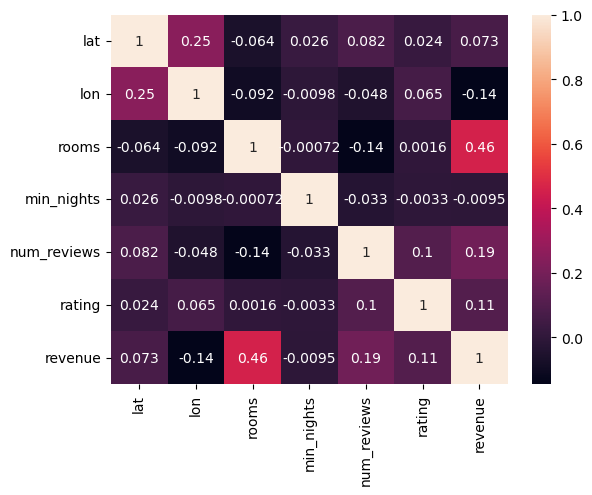

In [328]:
sns.heatmap(data=raw_train[['lat','lon','rooms','min_nights','num_reviews','rating', 'revenue']].corr(), annot=True)

# Feature selection & engineering

Baseline model used:
- Only numerical columns (lat, lon, rooms, num_reviews)

Features to keep for the model:
- lat
- lon
- rooms
- room_type
- min_nights
- num_reviews
- rating
- cancellation
- beds
- bathrooms
- guests

Features to drop for the model:
- host
- name
- listing_type
- facilities

Transformations required:
- Log transformation: to deal with skewness of revenue, rooms, min_nights, num_reviews, rating
- Normalization: on all numerical columns so that all are on same scale
- Median imputation, due to skewness: rooms (fill with 1 wherever room_type == shared room, hotel room or private room; fill with the median for all other missing values)
- Mean imputation: lat and lon
- Dummy encoding of categorical variables: room_type

2025-05-09 23:05:24,944 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000002488C944B30>


<Axes: >

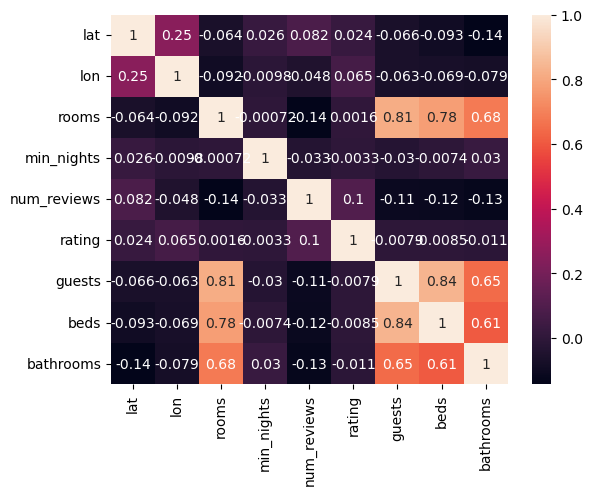

In [330]:
sns.heatmap(data=raw_train[['lat','lon','rooms','min_nights','num_reviews','rating', 'guests', 'beds','bathrooms']].corr(), annot=True)

## Engineer location feature

In [340]:
raw_train['lat_lon_product'] = raw_train['lat'] * raw_train['lon']
raw_valid['lat_lon_product'] = raw_valid['lat'] * raw_valid['lon']

## Engineer rating credibility feature

In [342]:
# Feature engineering on raw_train and raw_valid
raw_train['rating_weighted'] = raw_train['rating'] * np.log1p(raw_train['num_reviews'])
raw_valid['rating_weighted'] = raw_valid['rating'] * np.log1p(raw_valid['num_reviews'])

In [343]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,cancellation,revenue,rating_weighted,lat_lon_product
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3,766,4.91,2.0,Entire rental unit,Strict,46779,32.614610,-178.188371
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,95,151,4.40,4.0,Entire rental unit,Strict,5518,22.105074,703.971159
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1,194,4.72,4.0,Entire rental unit,Moderate,7734,24.888558,788.889019
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30,20,5.00,4.0,Entire rental unit,Strict,23147,15.222612,905.158948
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2,155,4.71,6.0,Entire rental unit,Moderate,13496,23.784822,997.759040


In [346]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,cancellation,revenue,rating_weighted,lat_lon_product
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,5.0,Entire condo,Strict,13809,14.221640,-305.917085
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,6.0,Entire rental unit,Strict,39868,14.199771,315.769410
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,2.0,Entire rental unit,Strict,7180,22.229060,1788.506622
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,2.0,Entire rental unit,Moderate,57623,29.337233,492.740780
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,6.0,Entire rental unit,Moderate,32048,25.184876,-354.156426


# Preprocessing Pipelines

In [348]:
# Prepare X and y
# Define label
label = 'revenue'

X_train = raw_train.drop(columns=[label])
y_train = raw_train[label]

X_valid = raw_valid.drop(columns=[label])
y_valid = raw_valid[label]

logging.info("Data loaded, cleaned, and split successfully.")

2025-05-09 23:08:33,296 - INFO - Data loaded, cleaned, and split successfully.


## Preprocessing v1: Simple Imputation

In [350]:
# Create list of transformations to apply in preprocessing
preprocess1 = ColumnTransformer(
    transformers=[
        # lat column: apply mean imputation and normalization
        ("lat", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), ["lat"]),
        # lon column: apply mean imputation and normalization
        ("lon", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), ["lon"]),
        # rooms column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("rooms", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rooms"]),
        # num_review column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("num_reviews", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["num_reviews"]),
        # min_nights column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("min_nights", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["min_nights"]),
        # rating column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("rating", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rating"]),
        # bathroom column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("bathrooms", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["bathrooms"]),
        # beds column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("beds", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["beds"]),
        # rating_weighted engineered feature: no imputation needed,already log scaled in calculation; applied normalization
         ("rating_weighted", Pipeline(steps=[
            ('scaler', MinMaxScaler())
        ]), ["rating_weighted"]),
        # room_type column: apply one-hot encoding
        ("room_type", OneHotEncoder(handle_unknown='ignore'), ["room_type"]),
        # cancellation column: apply imputation and one-hot encoding
        ("cancellation", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ["cancellation"]),
        # listing_type column: apply one-hot encoding
        # ("listing_type", OneHotEncoder(handle_unknown='ignore'), ["listing_type"])
    ],
    remainder='drop'
)
# Fit the preprocessing steps on the training data
#preprocess.fit(X_train)



## Preprocessing v2: Iterative Imputation (Round robin regression)

In [183]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# Define pipeline with IterativeImputer
preprocess2 = ColumnTransformer(
    transformers=[
        ("lat", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('scaler', MinMaxScaler())
        ]), ["lat"]),
        ("lon", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('scaler', MinMaxScaler())
        ]), ["lon"]),
        ("rooms", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rooms"]),
        ("num_reviews", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["num_reviews"]),
        ("min_nights", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["min_nights"]),
        ("rating", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rating"]),
        ("bathrooms", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["bathrooms"]),
        ("beds", Pipeline(steps=[
            ('imputer', IterativeImputer(random_state=r_state)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["beds"]),
        ("room_type", OneHotEncoder(handle_unknown='ignore'), ["room_type"]),
        ("cancellation", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ["cancellation"]),
        # ("listing_type", OneHotEncoder(handle_unknown='ignore'), ["listing_type"])
    ],
    remainder='drop'
)


# Fit the preprocessing steps on the training data
#preprocess.fit(X_train)



## Preprocessing v3: KNN Imputation

In [147]:
# from sklearn.impute import KNNImputer
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.preprocessing import FunctionTransformer

# Define pipeline with KNNImputer
preprocess3 = ColumnTransformer(
    ## KNN Imputer fore all numerical columns
    transformers=[
        ("lat", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', MinMaxScaler())
        ]), ["lat"]),
        ("lon", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', MinMaxScaler())
        ]), ["lon"]),
        ("rooms", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rooms"]),
        ("num_reviews", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["num_reviews"]),
        ("min_nights", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["min_nights"]),
        ("rating", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rating"]),
        ("bathrooms", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["bathrooms"]),
        ("beds", Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["beds"]),
        ("room_type", OneHotEncoder(handle_unknown='ignore'), ["room_type"]), ## no missing values identified, so no need for imputation
        ("cancellation", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')), ## KNN not suitable for categorical varialbe, so keep SimpleImputation
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ["cancellation"]),
        # ("listing_type", OneHotEncoder(handle_unknown='ignore'), ["listing_type"])
    ],
    remainder='drop'
)


## !Testing!

In [78]:
# Create list of transformations to apply in preprocessing
preprocess_guests = ColumnTransformer(
    transformers=[
        # lat column: apply mean imputation and normalization
        ("lat", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), ["lat"]),
        # lon column: apply mean imputation and normalization
        ("lon", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), ["lon"]),
        # rooms column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("rooms", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rooms"]),
        # num_review column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("num_reviews", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["num_reviews"]),
        # min_nights column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("min_nights", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["min_nights"]),
        # rating column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("rating", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["rating"]),
        # bathroom column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("bathrooms", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["bathrooms"]),
        # beds column: apply median imputation (skewed data), log transformation (skewed data) and normalization
        ("beds", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["beds"]),
        ("guests", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', MinMaxScaler())
        ]), ["guests"]),
        # room_type column: apply one-hot encoding
        ("room_type", OneHotEncoder(handle_unknown='ignore'), ["room_type"]),
        # cancellation column: apply imputation and one-hot encoding
        ("cancellation", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ["cancellation"]),
        #listing_type column: apply one-hot encoding
        # ("listing_type", OneHotEncoder(handle_unknown='ignore'), ["listing_type"])
    ],
    remainder='drop'
)
# Fit the preprocessing steps on the training data
#preprocess.fit(X_train)



# Testing different imputation methods

In [11]:
# Log-transform training target
y_train_log = np.log1p(y_train)  # Only log-transform once here  # log1p-transformed version of y_train for model fitting

In [352]:
# --------------------------
# Define and train model
# --------------------------
model = make_pipeline(
    preprocess1,
    LinearRegression()
)

logging.info("Fitting simple regression model with preprocessing")
model.fit(X_train, y_train_log)

# --------------------------
# Evaluate model
# --------------------------
train_preds = np.expm1(model.predict(X_train))
valid_preds = np.expm1(model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Train MAE: {train_mae:.2f}")
logging.info(f"Valid MAE: {valid_mae:.2f}")

2025-05-09 23:09:14,207 - INFO - Fitting simple regression model with preprocessing
2025-05-09 23:09:14,288 - INFO - Train MAE: 10954.68
2025-05-09 23:09:14,289 - INFO - Valid MAE: 10671.97


In [185]:
# --------------------------
# Define and train model
# --------------------------
model = make_pipeline(
    preprocess2,
    LinearRegression()
)

logging.info("Fitting simple regression model with preprocessing")
model.fit(X_train, y_train_log)

# --------------------------
# Evaluate model
# --------------------------
train_preds = np.expm1(model.predict(X_train))
valid_preds = np.expm1(model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Train MAE: {train_mae:.2f}")
logging.info(f"Valid MAE: {valid_mae:.2f}")

2025-05-09 21:51:44,717 - INFO - Fitting simple regression model with preprocessing
2025-05-09 21:51:44,789 - INFO - Train MAE: 11230.33
2025-05-09 21:51:44,790 - INFO - Valid MAE: 11007.32


In [187]:
# --------------------------
# Define and train model
# --------------------------
model = make_pipeline(
    preprocess3,
    LinearRegression()
)

logging.info("Fitting simple regression model with preprocessing")
model.fit(X_train, y_train_log)

# --------------------------
# Evaluate model
# --------------------------
train_preds = np.expm1(model.predict(X_train))
valid_preds = np.expm1(model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Train MAE: {train_mae:.2f}")
logging.info(f"Valid MAE: {valid_mae:.2f}")

2025-05-09 21:51:49,592 - INFO - Fitting simple regression model with preprocessing
2025-05-09 21:51:50,042 - INFO - Train MAE: 11230.33
2025-05-09 21:51:50,043 - INFO - Valid MAE: 11007.32


In [189]:
# --------------------------
# Define and train model
# --------------------------
model = make_pipeline(
    preprocess_guests,
    LinearRegression()
)

logging.info("Fitting simple regression model with preprocessing")
model.fit(X_train, y_train_log)

# --------------------------
# Evaluate model
# --------------------------
train_preds = np.expm1(model.predict(X_train))
valid_preds = np.expm1(model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Train MAE: {train_mae:.2f}")
logging.info(f"Valid MAE: {valid_mae:.2f}")

2025-05-09 21:52:04,274 - INFO - Fitting simple regression model with preprocessing
2025-05-09 21:52:04,358 - INFO - Train MAE: 11111.75
2025-05-09 21:52:04,359 - INFO - Valid MAE: 10895.53


# Lasso Regression

In [360]:
lasso_model = make_pipeline(
    preprocess1,
    Lasso(alpha=1,random_state=r_state)
)

logging.info("Fitting simple regression model with preprocessing")
lasso_model.fit(X_train, y_train_log)

# --------------------------
# Evaluate model
# --------------------------
train_preds = np.expm1(lasso_model.predict(X_train))
valid_preds = np.expm1(lasso_model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Train MAE: {train_mae:.2f}")
logging.info(f"Valid MAE: {valid_mae:.2f}")

2025-05-09 23:32:08,517 - INFO - Fitting simple regression model with preprocessing
2025-05-09 23:32:08,584 - INFO - Train MAE: 14798.56
2025-05-09 23:32:08,585 - INFO - Valid MAE: 14397.86


# Ridge Regression

## Baseline

In [362]:
ridge_model = make_pipeline(
    preprocess1,
    Ridge(alpha=1,random_state=r_state)
)

logging.info("Fitting simple regression model with preprocessing")
ridge_model.fit(X_train, y_train_log)

# --------------------------
# Evaluate model
# --------------------------
train_preds = np.expm1(ridge_model.predict(X_train))
valid_preds = np.expm1(ridge_model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Train MAE: {train_mae:.2f}")
logging.info(f"Valid MAE: {valid_mae:.2f}")

2025-05-09 23:32:27,114 - INFO - Fitting simple regression model with preprocessing
2025-05-09 23:32:27,182 - INFO - Train MAE: 10973.35
2025-05-09 23:32:27,182 - INFO - Valid MAE: 10694.86


## Ridge GridSearch

In [230]:
ridge_model = make_pipeline(
    preprocess_guests,
    Ridge(random_state=r_state)
)

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100],  # try smaller/larger if needed
    'ridge__solver': ['auto', 'saga']  # optional: test different solvers
}


grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

logging.info("Starting GridSearchCV for Ridge Regression...")
grid_search_ridge.fit(X_train, y_train_log)


best_ridge_model = grid_search_ridge.best_estimator_

train_preds_log = best_ridge_model.predict(X_train)
valid_preds_log = best_ridge_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Ridge Train MAE: {train_mae:.2f}")
logging.info(f"Ridge Valid MAE: {valid_mae:.2f}")
logging.info(f"Best Ridge Params: {grid_search_ridge.best_params_}")


2025-05-09 22:01:04,418 - INFO - Starting GridSearchCV for Ridge Regression...


Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025-05-09 22:01:05,338 - INFO - Ridge Train MAE: 11113.01
2025-05-09 22:01:05,339 - INFO - Ridge Valid MAE: 10896.62
2025-05-09 22:01:05,339 - INFO - Best Ridge Params: {'ridge__alpha': 1, 'ridge__solver': 'saga'}


# KNN

## Baseline

In [125]:
# Create the KNN pipeline using your existing preprocess1
knn_model = make_pipeline(
    preprocess1,
    KNeighborsRegressor(n_neighbors=5, weights='distance', metric='minkowski')  # You can tune these
)

knn_model.fit(X_train, y_train_log)

train_preds_log = knn_model.predict(X_train)
valid_preds_log = knn_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"KNN Train MAE: {train_mae:.2f}")
print(f"KNN Valid MAE: {valid_mae:.2f}")

KNN Train MAE: 0.00
KNN Valid MAE: 10455.53


## KNN Preprocess1 + GridSearch

In [138]:
# Define pipeline
knn_pipeline = make_pipeline(
    preprocess1,
    KNeighborsRegressor()
)

# Define hyperparameter grid
param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 10, 15, 20, 25, 30],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

# Run randomized search
grid_search_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)


grid_search_knn.fit(X_train, y_train_log)

# Best model
best_knn_model = grid_search_knn.best_estimator_

# Predict and evaluate
train_preds_log = best_knn_model.predict(X_train)
valid_preds_log = best_knn_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"KNN (Tuned) Train MAE: {train_mae:.2f}")
logging.info(f"KNN (Tuned) Valid MAE: {valid_mae:.2f}")
logging.info(f"Best KNN params: {grid_search_knn.best_params_}")


2025-05-09 21:36:36,228 - INFO - Starting RandomizedSearchCV for KNN...


Fitting 5 folds for each of 56 candidates, totalling 280 fits


2025-05-09 21:36:57,265 - INFO - KNN (Tuned) Train MAE: 0.00
2025-05-09 21:36:57,266 - INFO - KNN (Tuned) Valid MAE: 10093.39
2025-05-09 21:36:57,266 - INFO - Best KNN params: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__weights': 'distance'}


## KNN Preprocess3 + GridSearch

In [152]:
knn_pipeline = make_pipeline(
    preprocess3,
    KNeighborsRegressor()
)

# Define hyperparameter grid
param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 10, 15, 20, 25, 30],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

# Run randomized search
grid_search_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)


grid_search_knn.fit(X_train, y_train_log)

# Best model
best_knn_model = grid_search_knn.best_estimator_

# Predict and evaluate
train_preds_log = best_knn_model.predict(X_train)
valid_preds_log = best_knn_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"KNN (Tuned) Train MAE: {train_mae:.2f}")
logging.info(f"KNN (Tuned) Valid MAE: {valid_mae:.2f}")
logging.info(f"Best KNN params: {best_knn_model.best_params_}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits


2025-05-09 21:40:00,623 - INFO - KNN (Tuned) Train MAE: 0.00
2025-05-09 21:40:00,624 - INFO - KNN (Tuned) Valid MAE: 10098.45
2025-05-09 21:40:00,624 - INFO - Best KNN params: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__weights': 'distance'}


# Random Forest

## Baseline

In [81]:
# Define the pipeline with SimpleImputer
rf_model = make_pipeline(
    preprocess1,
    RandomForestRegressor(random_state=r_state)
)

rf_model.fit(X_train, y_train_log)  # fit on log-transformed target


train_preds_log = rf_model.predict(X_train)
valid_preds_log = rf_model.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")

2025-05-09 17:53:52,561 - INFO - RandomForest MAE on train set: 4084.90
2025-05-09 17:53:52,561 - INFO - RandomForest MAE on validation set: 9349.84


## RF Random Search

In [37]:
# Define the pipeline with SimpleImputer
rf_pipeline = make_pipeline(
    preprocess1,
    RandomForestRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'randomforestregressor__max_depth': [None, 10, 20, 30, 40, 50],
    'randomforestregressor__n_estimators': [50, 100, 200, 300, 400, 500],
    'randomforestregressor__min_samples_split': [2, 5, 10, 20]
}

# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for RandomForest with SimpleImputer...")
random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_rf_model = random_search.best_estimator_

train_preds_log = best_rf_model.predict(X_train)
valid_preds_log = best_rf_model.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


2025-05-09 17:35:43,540 - INFO - Starting RandomizedSearchCV for RandomForest with SimpleImputer...


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-05-09 17:38:49,548 - INFO - RandomForest MAE on train set: 6008.89
2025-05-09 17:38:49,549 - INFO - RandomForest MAE on validation set: 9344.47
2025-05-09 17:38:49,549 - INFO - Best params: {'randomforestregressor__n_estimators': 500, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__max_depth': 30}


# Gradient Boosted Regressor

## Baseline

In [83]:

gbr_model = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

gbr_model.fit(X_train, y_train_log)


train_preds_log = gbr_model.predict(X_train)
valid_preds_log = gbr_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

2025-05-09 17:53:58,128 - INFO - Gradient Boosting Train MAE: 9546.80
2025-05-09 17:53:58,128 - INFO - Gradient Boosting Valid MAE: 9521.16


## GBR RandomSearch

### Selected for voting

In [98]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model1 = random_search.best_estimator_

train_preds_log = best_gbr_model1.predict(X_train)
valid_preds_log = best_gbr_model1.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:59:27,278 - INFO - RandomForest MAE on train set: 7675.97
2025-05-09 19:59:27,278 - INFO - RandomForest MAE on validation set: 8753.27
2025-05-09 19:59:27,278 - INFO - Best params: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}


## !Testing!

In [160]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess_guests,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model2 = random_search.best_estimator_

train_preds_log = best_gbr_model2.predict(X_train)
valid_preds_log = best_gbr_model2.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 21:43:41,117 - INFO - RandomForest MAE on train set: 7558.46
2025-05-09 21:43:41,118 - INFO - RandomForest MAE on validation set: 8768.42
2025-05-09 21:43:41,118 - INFO - Best params: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}


# XGBoost

## Baseline

In [87]:
from xgboost import XGBRegressor

xgb_model = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

xgb_model.fit(X_train, y_train_log)


train_preds_log = xgb_model.predict(X_train)
valid_preds_log = xgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

2025-05-09 17:54:08,450 - INFO - Gradient Boosting Train MAE: 6275.06
2025-05-09 17:54:08,451 - INFO - Gradient Boosting Valid MAE: 9083.43


## XGB RandomSearch

In [91]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__min_child_weight': [1, 3, 5]
}

# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model = random_search.best_estimator_

train_preds_log = best_xgb_model.predict(X_train)
valid_preds_log = best_xgb_model.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

2025-05-09 19:55:06,582 - INFO - Starting RandomizedSearchCV for XGBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:55:17,077 - INFO - XGBoost MAE on train set: 7376.08
2025-05-09 19:55:17,078 - INFO - XGBoost MAE on validation set: 8774.32
2025-05-09 19:55:17,078 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__n_estimators': 300, 'xgbregressor__min_child_weight': 1, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__colsample_bytree': 0.8}


## !Testing!

### Selected for voting

In [96]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model1 = random_search.best_estimator_

train_preds_log = best_xgb_model1.predict(X_train)
valid_preds_log = best_xgb_model1.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

2025-05-09 19:58:09,094 - INFO - Starting RandomizedSearchCV for XGBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:58:26,114 - INFO - XGBoost MAE on train set: 7834.01
2025-05-09 19:58:26,115 - INFO - XGBoost MAE on validation set: 8715.70
2025-05-09 19:58:26,115 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1.0, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__n_estimators': 400, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0, 'xgbregressor__colsample_bytree': 1.0}


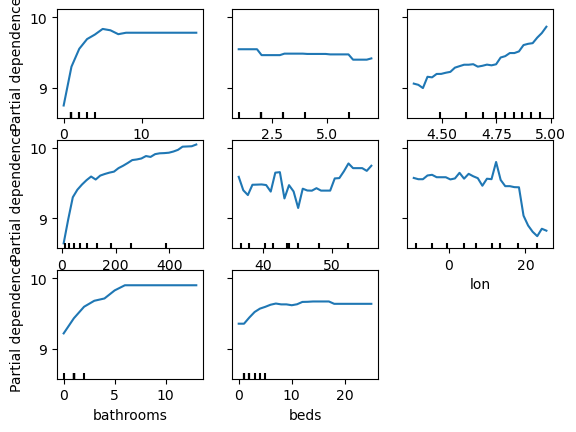

In [61]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use raw X_train (NOT transformed — the pipeline handles that)
PartialDependenceDisplay.from_estimator(
    best_xgb_model,                # your full fitted pipeline
    X_train,                       # raw features with column names
    features=['rooms', 'min_nights', 'rating', 'num_reviews', 'lat', 'lon', 'bathrooms', 'beds'],  # any continuous feature names
    kind='average',
    grid_resolution=30
)
plt.show()




In [63]:
# Turn search results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Convert the score to positive MAE
results['mae'] = -results['mean_test_score']

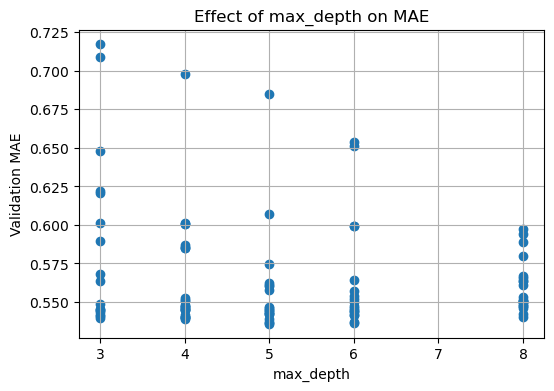

In [65]:
plt.figure(figsize=(6, 4))
plt.scatter(results['param_xgbregressor__max_depth'], results['mae'])
plt.xlabel('max_depth')
plt.ylabel('Validation MAE')
plt.title('Effect of max_depth on MAE')
plt.grid(True)
plt.show()



In [162]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess_guests,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model2 = random_search.best_estimator_

train_preds_log = best_xgb_model2.predict(X_train)
valid_preds_log = best_xgb_model2.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

2025-05-09 21:44:20,904 - INFO - Starting RandomizedSearchCV for XGBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 21:44:39,596 - INFO - XGBoost MAE on train set: 7718.58
2025-05-09 21:44:39,596 - INFO - XGBoost MAE on validation set: 8722.10
2025-05-09 21:44:39,597 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1.0, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__n_estimators': 400, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0, 'xgbregressor__colsample_bytree': 1.0}


# HistGradientRegressor

## Baseline

In [65]:

hgb_model = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

logging.info("Fitting HistGradientBoostingRegressor...")
hgb_model.fit(X_train, y_train_log)


train_preds_log = hgb_model.predict(X_train)
valid_preds_log = hgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")

2025-05-09 17:47:10,221 - INFO - Fitting HistGradientBoostingRegressor...
2025-05-09 17:47:10,594 - INFO - HistGradientBoosting Train MAE: 8244.27
2025-05-09 17:47:10,594 - INFO - HistGradientBoosting Valid MAE: 8855.14


## HistGradient RandomSearch

In [101]:


# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid = {
    'histgradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300],
    'histgradientboostingregressor__max_depth': [None, 5, 10],
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 1.0]
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model.predict(X_train))
valid_preds = np.expm1(best_hgb_model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-05-09 18:05:40,606 - INFO - HistGradientBoosting Train MAE: 8147.52
2025-05-09 18:05:40,607 - INFO - HistGradientBoosting Valid MAE: 8812.80
2025-05-09 18:05:40,607 - INFO - Best params: {'histgradientboostingregressor__min_samples_leaf': 10, 'histgradientboostingregressor__max_iter': 300, 'histgradientboostingregressor__max_depth': 5, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 0.0}


## !Testing!

### Selected for voting 

In [94]:
# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess_guests,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model1 = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model1.predict(X_train))
valid_preds = np.expm1(best_hgb_model1.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:57:48,897 - INFO - HistGradientBoosting Train MAE: 7502.00
2025-05-09 19:57:48,899 - INFO - HistGradientBoosting Valid MAE: 8741.81
2025-05-09 19:57:48,899 - INFO - Best params: {'histgradientboostingregressor__scoring': None, 'histgradientboostingregressor__monotonic_cst': None, 'histgradientboostingregressor__min_samples_leaf': 10, 'histgradientboostingregressor__max_leaf_nodes': 63, 'histgradientboostingregressor__max_iter': 500, 'histgradientboostingregressor__max_depth': 5, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 0.1, 'histgradientboostingregressor__early_stopping': False, 'histgradientboostingregressor__categorical_features': None}


# Model Stacking

In [241]:
from sklearn.ensemble import StackingRegressor
stack = StackingRegressor(
    estimators=[
        ('gbr', best_gbr_model1),
        ('xgb', best_xgb_model1),
        ('hgr', best_hgb_model1),
        ('ridge', ridge_model),
        ('knn', best_knn_model)
    ],
    final_estimator=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=r_state)
)
stack.fit(X_train, y_train_log)


StackingRegressor(estimators=[('gbr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('lat',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer()),
                                                                                                 ('scaler',
                                                                                                  MinMaxScaler())]),
                                                                                 ['lat']),
                                                                                ('lon',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer()),
                                                                                                 ('scaler',
                                                                                                  MinMaxScaler())]),
                                                                                 ['lon']),
                                                                                ('rooms',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')...
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['room_type']),
                                                                                ('cancellation',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehot',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['cancellation'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(metric='manhattan',
                                                                    n_neighbors=15,
                                                                    weights='distance'))]))],
                  final_estimator=GradientBoostingRegressor(random_state=123))

In [243]:
# Predict log-transformed outputs
train_preds_log = stack.predict(X_train)
valid_preds_log = stack.predict(X_valid)

# Inverse transform to original scale
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate MAE
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"StackingRegressor Train MAE: {train_mae:.2f}")
print(f"StackingRegressor Valid MAE: {valid_mae:.2f}")

StackingRegressor Train MAE: 7499.93
StackingRegressor Valid MAE: 8701.89


# CatBoost

In [263]:
# pip install catboost ## Only run once
from catboost import CatBoostRegressor

# Define the pipeline
catboost_pipeline = make_pipeline(
    preprocess1,
    CatBoostRegressor(
        loss_function='RMSE',
        verbose=0,
        random_state=r_state
    )
)

# Define hyperparameter grid
param_grid = {
    'catboostregressor__iterations': [300, 500, 700, 1000],
    'catboostregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'catboostregressor__depth': [4, 6, 8, 10],
    'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 10],
    'catboostregressor__bootstrap_type': ['Bayesian', 'Bernoulli'],
    #'catboostregressor__bagging_temperature': [0, 1, 5, 10]
}

# Run RandomizedSearchCV
random_search_cat = RandomizedSearchCV(
    estimator=catboost_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for CatBoost...")
random_search_cat.fit(X_train, y_train_log)

# Get best model
best_cat_model = random_search_cat.best_estimator_

# Predict
train_preds_log = best_cat_model.predict(X_train)
valid_preds_log = best_cat_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"CatBoost Train MAE: {train_mae:.2f}")
logging.info(f"CatBoost Valid MAE: {valid_mae:.2f}")
logging.info(f"Best CatBoost Params: {random_search_cat.best_params_}")



2025-05-09 22:29:28,968 - INFO - Starting RandomizedSearchCV for CatBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 22:37:05,967 - INFO - CatBoost Train MAE: 8466.12
2025-05-09 22:37:05,967 - INFO - CatBoost Valid MAE: 8752.48
2025-05-09 22:37:05,968 - INFO - Best CatBoost Params: {'catboostregressor__learning_rate': 0.1, 'catboostregressor__l2_leaf_reg': 10, 'catboostregressor__iterations': 1000, 'catboostregressor__depth': 4, 'catboostregressor__bootstrap_type': 'Bayesian'}


# LightGBM

In [261]:
# pip install lightgbm ## Only run once
from lightgbm import LGBMRegressor

# Define the pipeline
lgbm_pipeline = make_pipeline(
    preprocess_guests,
    LGBMRegressor(
        objective='regression',
        random_state=r_state,
        verbose=-1
    )
)

# Define hyperparameter grid
param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300, 500],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__max_depth': [-1, 4, 6, 8, 10],
    'lgbmregressor__num_leaves': [15, 31, 63, 127],
    'lgbmregressor__min_child_samples': [5, 10, 20, 50],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmregressor__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'lgbmregressor__reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Run RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for LightGBM...")
random_search_lgbm.fit(X_train, y_train_log)

# Best model
best_lgbm_model = random_search_lgbm.best_estimator_

# Predict
train_preds_log = best_lgbm_model.predict(X_train)
valid_preds_log = best_lgbm_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"LightGBM Train MAE: {train_mae:.2f}")
logging.info(f"LightGBM Valid MAE: {valid_mae:.2f}")
logging.info(f"Best LightGBM Params: {random_search_lgbm.best_params_}")



2025-05-09 22:26:52,547 - INFO - Starting RandomizedSearchCV for LightGBM...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-05-09 22:28:02,089 - INFO - LightGBM Train MAE: 6999.99
2025-05-09 22:28:02,089 - INFO - LightGBM Valid MAE: 8721.26
2025-05-09 22:28:02,090 - INFO - Best LightGBM Params: {'lgbmregressor__subsample': 1.0, 'lgbmregressor__reg_lambda': 0.5, 'lgbmregressor__reg_alpha': 0.1, 'lgbmregressor__num_leaves': 127, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__min_child_samples': 10, 'lgbmregressor__max_depth': 6, 'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__colsample_bytree': 0.6}


In [259]:

# Define the pipeline
lgbm_pipeline = make_pipeline(
    preprocess1,
    LGBMRegressor(
        objective='regression',
        random_state=r_state,
        verbose=-1
    )
)

# Define hyperparameter grid
param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300, 500],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__max_depth': [-1, 4, 6, 8, 10],
    'lgbmregressor__num_leaves': [15, 31, 63, 127],
    'lgbmregressor__min_child_samples': [5, 10, 20, 50],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmregressor__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'lgbmregressor__reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Run RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for LightGBM...")
random_search_lgbm.fit(X_train, y_train_log)

# Best model
best_lgbm_model = random_search_lgbm.best_estimator_

# Predict
train_preds_log = best_lgbm_model.predict(X_train)
valid_preds_log = best_lgbm_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"LightGBM Train MAE: {train_mae:.2f}")
logging.info(f"LightGBM Valid MAE: {valid_mae:.2f}")
logging.info(f"Best LightGBM Params: {random_search_lgbm.best_params_}")



2025-05-09 22:25:26,469 - INFO - Starting RandomizedSearchCV for LightGBM...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-05-09 22:26:34,039 - INFO - LightGBM Train MAE: 7158.35
2025-05-09 22:26:34,040 - INFO - LightGBM Valid MAE: 8751.35
2025-05-09 22:26:34,040 - INFO - Best LightGBM Params: {'lgbmregressor__subsample': 1.0, 'lgbmregressor__reg_lambda': 0.5, 'lgbmregressor__reg_alpha': 0.1, 'lgbmregressor__num_leaves': 127, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__min_child_samples': 10, 'lgbmregressor__max_depth': 6, 'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__colsample_bytree': 0.6}


# Voting Regressor

## Mixed features

In [266]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr_model1),
    ('xgb', best_xgb_model1),
    ('hgb', best_hgb_model1),
    ('lgbm', best_lgbm_model),
    ('cat', best_cat_model)
    #('ridge', ridge_model)
])
## Best model so far: validation MAE 8632

In [268]:
voting_model.fit(X_train, y_train_log)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('lat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lat']),
                                                                              ('lon',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lon']),
                                                                              ('rooms',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),...
                                                                                                                    validate=True)),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['beds']),
                                                                              ('room_type',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['room_type']),
                                                                              ('cancellation',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cancellation'])])),
                                             ('catboostregressor',
                                              <catboost.core.CatBoostRegressor object at 0x00000248F6ACA960>)]))])

In [270]:
# Predict (log scale → exp transform)
train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")


C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


VotingRegressor Train MAE: 7603.67
VotingRegressor Valid MAE: 8632.19


## All same features (all have guests column added in preprocessing)

In [168]:
# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr_model2),
    ('xgb', best_xgb_model2),
    ('hgb', best_hgb_model1)
])

In [170]:
voting_model.fit(X_train, y_train_log)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('lat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lat']),
                                                                              ('lon',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lon']),
                                                                              ('rooms',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cancellation'])])),
                                             ('histgradientboostingregressor',
                                              HistGradientBoostingRegressor(categorical_features=None,
                                                                            early_stopping=False,
                                                                            l2_regularization=0.1,
                                                                            learning_rate=0.05,
                                                                            max_depth=5,
                                                                            max_iter=500,
                                                                            max_leaf_nodes=63,
                                                                            min_samples_leaf=10,
                                                                            random_state=123,
                                                                            scoring=None))]))])

In [172]:
# Predict (log scale → exp transform)
train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")


VotingRegressor Train MAE: 7531.52
VotingRegressor Valid MAE: 8679.83


## Different imputation methods

In [205]:
# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr_model1),
    ('xgb', best_xgb_model1),
    ('hgb', best_hgb_model1),
    ('knn', best_knn_model),
    ('ridge',ridge_model)
])

In [207]:
voting_model.fit(X_train, y_train_log)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('lat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lat']),
                                                                              ('lon',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lon']),
                                                                              ('rooms',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),...
                                                                                                FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                    validate=True)),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['guests']),
                                                                              ('room_type',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['room_type']),
                                                                              ('cancellation',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cancellation'])])),
                                             ('ridge',
                                              Ridge(alpha=1,
                                                    random_state=123))]))])

In [209]:
# Predict (log scale → exp transform)
train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")

VotingRegressor Train MAE: 6738.59
VotingRegressor Valid MAE: 8987.19
